In [55]:
# imports
import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
parquet_file = '../nyc_energy_clean.parquet'

In [56]:
# literally just copied and pasted this from the data.py file.
# this makes a DB in memory, called buildings. it reads from the parquet file which is the FULL one, nyc_energy_clean.parquet
# also printed out the first 5 rows and all 21 columns we have
con = duckdb.connect(database=':memory:')
df = con.execute(f"""
SELECT *
FROM '{parquet_file}'
""").fetchdf()

# print("Parquet file loaded into DuckDB as table 'buildings'.")
# df.head()
# print(df.dtypes)

In [57]:
# any of the 21 columns, that have values with a comma, say 1,200 or 57,123 or 52,941 pandas cannot treat it as a number
# so remove the commas to treat it like one. above i ran print(df.dtypes) and it shows that most of the columns are objects
# when they should be numbers bc it helps the visualization. cant really visualize objects

convert_objectcols_to_numbercols = [
    "Property GFA - Calculated (Buildings) (ft²)",
    "Site Energy Use (kBtu)",
    "Weather Normalized Site Energy Use (kBtu)",
    "Electricity Use - Grid Purchase (kWh)",
    "Natural Gas Use (therms)",
    "Site EUI (kBtu/ft²)",
    "Weather Normalized Site EUI (kBtu/ft²)",
    "ENERGY STAR Score",
    "Total (Location-Based) GHG Emissions (Metric Tons CO2e)",
    "Total (Location-Based) GHG Emissions Intensity (kgCO2e/ft²)"
]

for col in convert_objectcols_to_numbercols:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(",", ""), errors="coerce")

# df[convert_objectcols_to_numbercols].head()

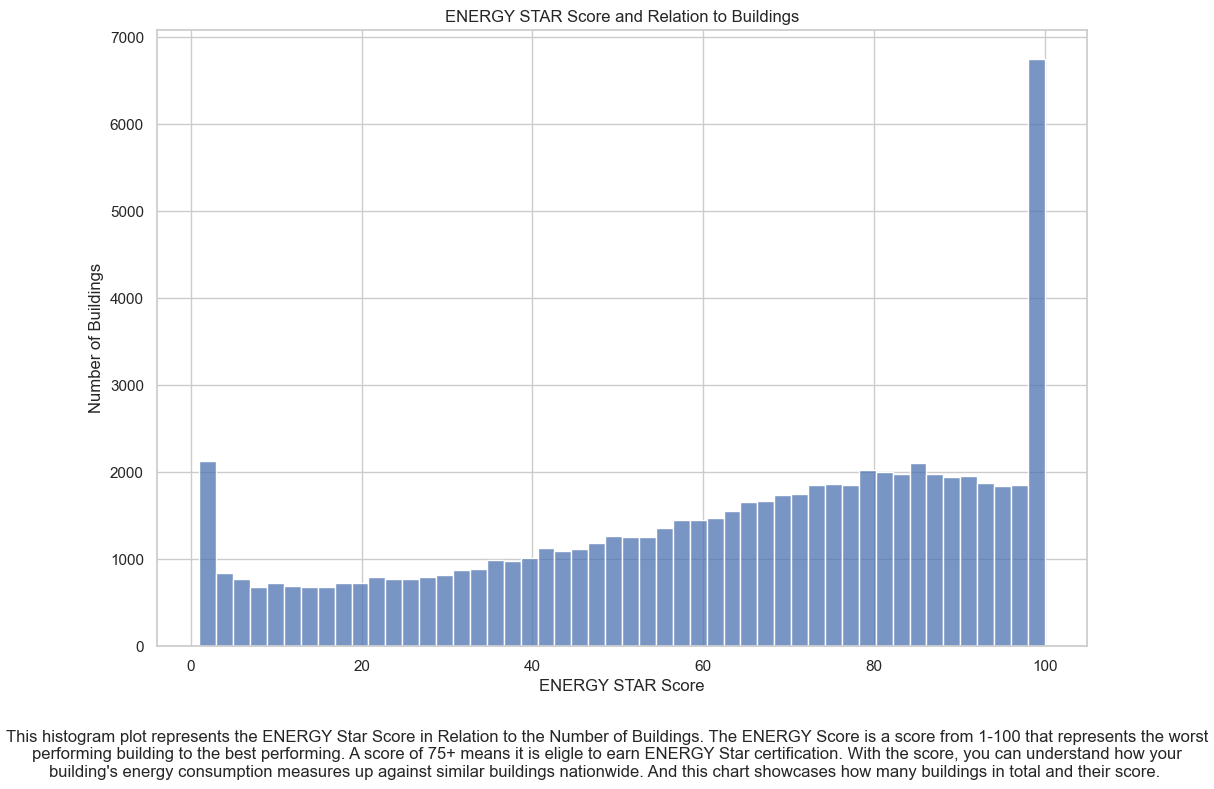

In [58]:
# the first and easiest plot to make is for the ENERGY STAR Score. According to NYC Open Data, this is a score from 1-100  and it represents 
# the worst performing buildings (1) to the best (100). "A score of 75 indicates that a property is performing in the 75th percentile and may be 
# eligible to earn ENERGY STAR Certification."
plt.figure(figsize=(12,8))
sns.histplot(df["ENERGY STAR Score"].dropna(), bins=50)
plt.title("ENERGY STAR Score and Relation to Buildings")
plt.xlabel("ENERGY STAR Score")
plt.ylabel("Number of Buildings")
plt.gcf().text(0.5, -0.05, 
               "This histogram plot represents the ENERGY Star Score in Relation to the Number of Buildings. The ENERGY Score is a score from 1-100 that represents the worst performing building to the best performing. A score of 75+ means it is eligle to earn ENERGY Star certification. With the score, you can understand how your building's energy consumption measures up against similar buildings nationwide. And this chart showcases how many buildings in total and their score. ", 
               ha='center', fontsize=12, wrap=True)
plt.show()

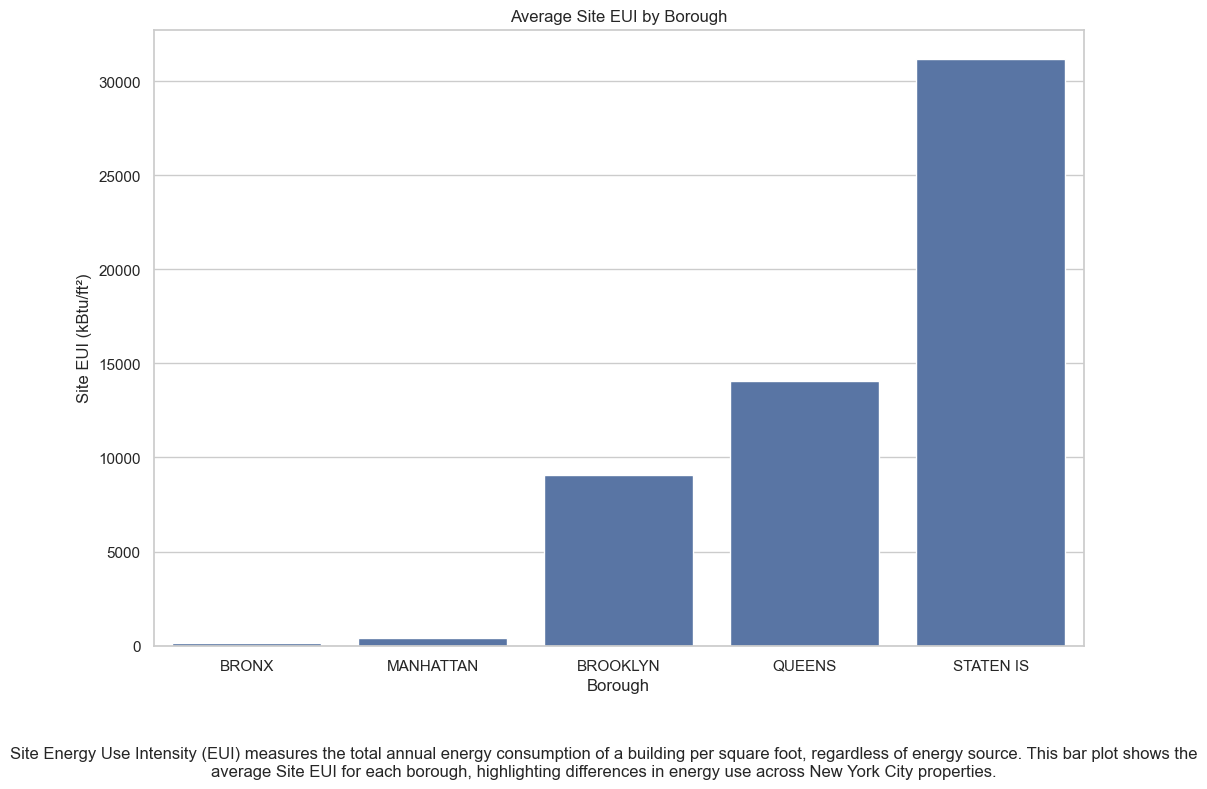

In [59]:
# next up is the Site Energy Use (kBtu). so according to the website, what this does is calculate the annual amount of all the energy your property 
# consumes on-site, regardless of the source. and I came up with this plot because it also says "Site Energy can be used to understand how the energy 
# use for an individual property has changed over time." so I did it for each borough and found the average.
borough_site_eui = df.groupby("Borough")["Site EUI (kBtu/ft²)"].mean().sort_values()
plt.figure(figsize=(12,8))
sns.barplot(x=borough_site_eui.index, y=borough_site_eui.values)
plt.title("Average Site EUI by Borough")
plt.xlabel("Borough")
plt.ylabel("Site EUI (kBtu/ft²)")
plt.gcf().text(0.5, -0.05, 
               "Site Energy Use Intensity (EUI) measures the total annual energy consumption of a building per square foot, regardless of energy source. This bar plot shows the average Site EUI for each borough, highlighting differences in energy use across New York City properties.", 
               ha='center', fontsize=12, wrap=True)
plt.show()

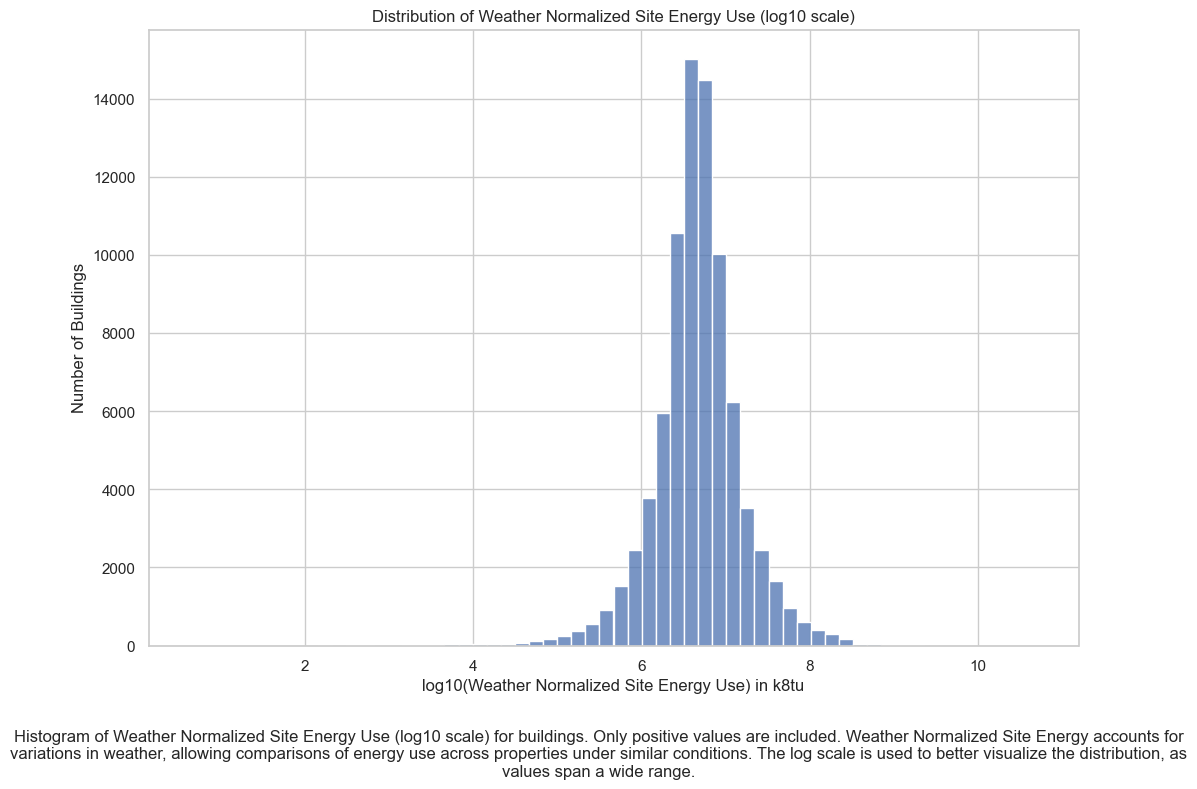

In [60]:
# this is an ai generated cell, i didnt know how to make the drawing for this because there were too many negative values here. and that made the
# original plot of mine to be wrong.
col = "Weather Normalized Site Energy Use (kBtu)"
df_filtered = df[df[col] > 0]

plt.figure(figsize=(12,8))
sns.histplot(np.log10(df_filtered[col]), bins=60)
plt.title("Distribution of Weather Normalized Site Energy Use (log10 scale)")
plt.xlabel("log10(Weather Normalized Site Energy Use) in k8tu")
plt.ylabel("Number of Buildings")
plt.gcf().text(0.5, -0.05, 
               "Histogram of Weather Normalized Site Energy Use (log10 scale) for buildings. Only positive values are included. Weather Normalized Site Energy accounts for variations in weather, allowing comparisons of energy use across properties under similar conditions. The log scale is used to better visualize the distribution, as values span a wide range.", 
               ha='center', fontsize=12, wrap=True)
plt.show()

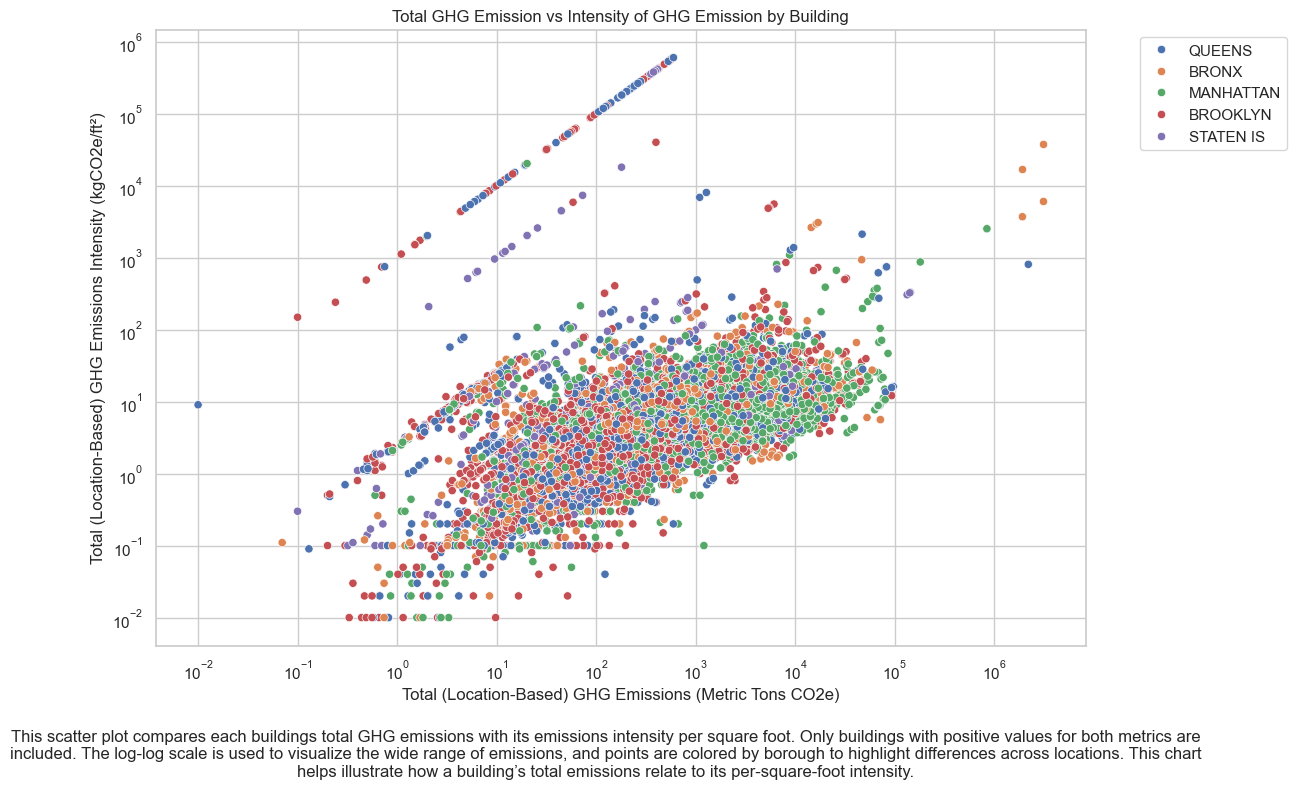

In [61]:
# now one thing i noticed in the 21 columns is that there are two that are basically identical, it's Total (Location-Based) GHG Emissions 
# (Metric Tons CO2e) and Total (Location-Based) GHG Emissions Intensity (kgCO2e/ft²). and i figured why not compare values. and the best way
# is a scatterplot. i did have to clean the data and log it bc a lot of values were in the negatives. 
# this scatter plot compares each buildings total GHG emissions with its emissions intensity per square foot.

df_clean = df[
    (df["Total (Location-Based) GHG Emissions (Metric Tons CO2e)"] > 0) &
    (df["Total (Location-Based) GHG Emissions Intensity (kgCO2e/ft²)"] > 0)
]
plt.figure(figsize=(12,8))
sns.scatterplot(
    data=df_clean,
    x="Total (Location-Based) GHG Emissions (Metric Tons CO2e)",
    y="Total (Location-Based) GHG Emissions Intensity (kgCO2e/ft²)",
    hue="Borough",
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Total (Location-Based) GHG Emissions (Metric Tons CO2e)")
plt.ylabel("Total (Location-Based) GHG Emissions Intensity (kgCO2e/ft²)")
plt.title("Total GHG Emission vs Intensity of GHG Emission by Building")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gcf().text(0.5, -0.05, 
               "This scatter plot compares each buildings total GHG emissions with its emissions intensity per square foot. Only buildings with positive values for both metrics are included. The log-log scale is used to visualize the wide range of emissions, and points are colored by borough to highlight differences across locations. This chart helps illustrate how a building’s total emissions relate to its per-square-foot intensity.", 
               ha='center', fontsize=12, wrap=True)
plt.show()

So the columns that I currently focused on in according to the plots. 
1. ENERGY STAR Score
2. Site EUI (kBtu/ft²)
3. Weather Normalized Site EUI (kBtu/ft²)
4. Total (Location-Based) GHG Emissions (Metric Tons CO2e) and Total (Location-Based) GHG Emissions Intensity (kgCO2e/ft²)

12/3/25:
5. Neighborhood Tabulation Area (NTA) (2020). For this I decided since we have a Neighborhood Tabulation Area (NTA), I get the top 10 or so and plot it with something else. The something else is
the Total GHG Emissions (Metric Tons CO2e). These neighborhoods contribute the most to overall 
carbon output.
6. Electricity Use - Grid Purchase (kWh). This is the electricity usage per building. So here, what I did is that make a scatter plot that shows the size of each building in relation to the
electricity usage. The bigger the building is, the more likely it uses more electricity. And the smaller it is, the less likely it uses more electricity. Simple scatter plot. 

- Wanted to do a heatmap, but wasnt sure what to add or how to exactly do it. 

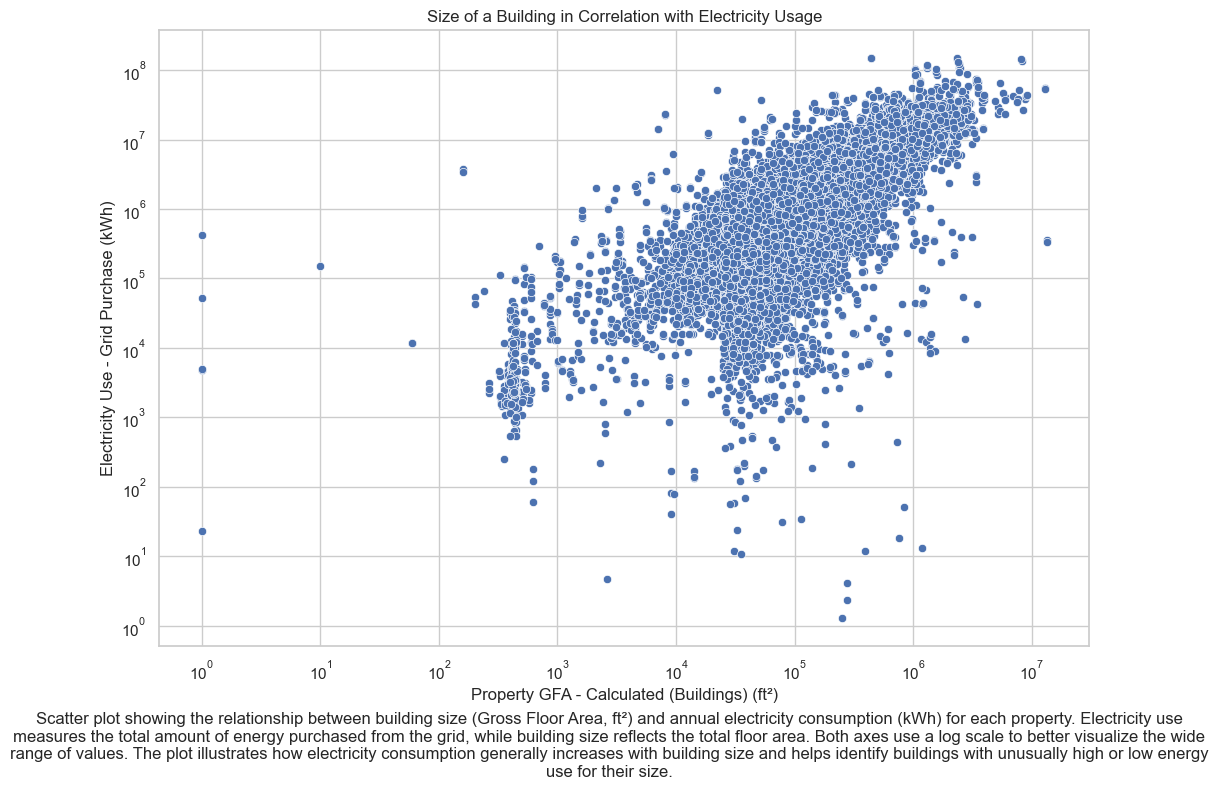

In [62]:
# so this is another scatter plot. electricity use is basically a summary of the annual consumption
# of an individual type of energy, such as electricity or natural gas. I decided, every building uses
# either electricity or natual gas. using the size of the buildings, why not see which buildings size
# uses the most, whats the most common, and which uses the least and less common. and i had to log it
# bc if i didnt, it was all near 0's and 0.2 and looked weird. 
# basically this scatter plot shows the size of the building in correlation with electrictity useage. 

plt.figure(figsize=(12,8))
sns.scatterplot(
    data=df,
    x="Property GFA - Calculated (Buildings) (ft²)",
    y="Electricity Use - Grid Purchase (kWh)",
)
plt.xscale("log")
plt.yscale("log")
plt.title("Size of a Building in Correlation with Electricity Usage")
plt.xlabel("Property GFA - Calculated (Buildings) (ft²)")
plt.ylabel("Electricity Use - Grid Purchase (kWh)")
plt.gcf().text(0.5, -0.05, 
               "Scatter plot showing the relationship between building size (Gross Floor Area, ft²) and annual electricity consumption (kWh) for each property. Electricity use measures the total amount of energy purchased from the grid, while building size reflects the total floor area. Both axes use a log scale to better visualize the wide range of values. The plot illustrates how electricity consumption generally increases with building size and helps identify buildings with unusually high or low energy use for their size.", 
               ha='center', fontsize=12, wrap=True)
plt.show()

C:\Users\hamim\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


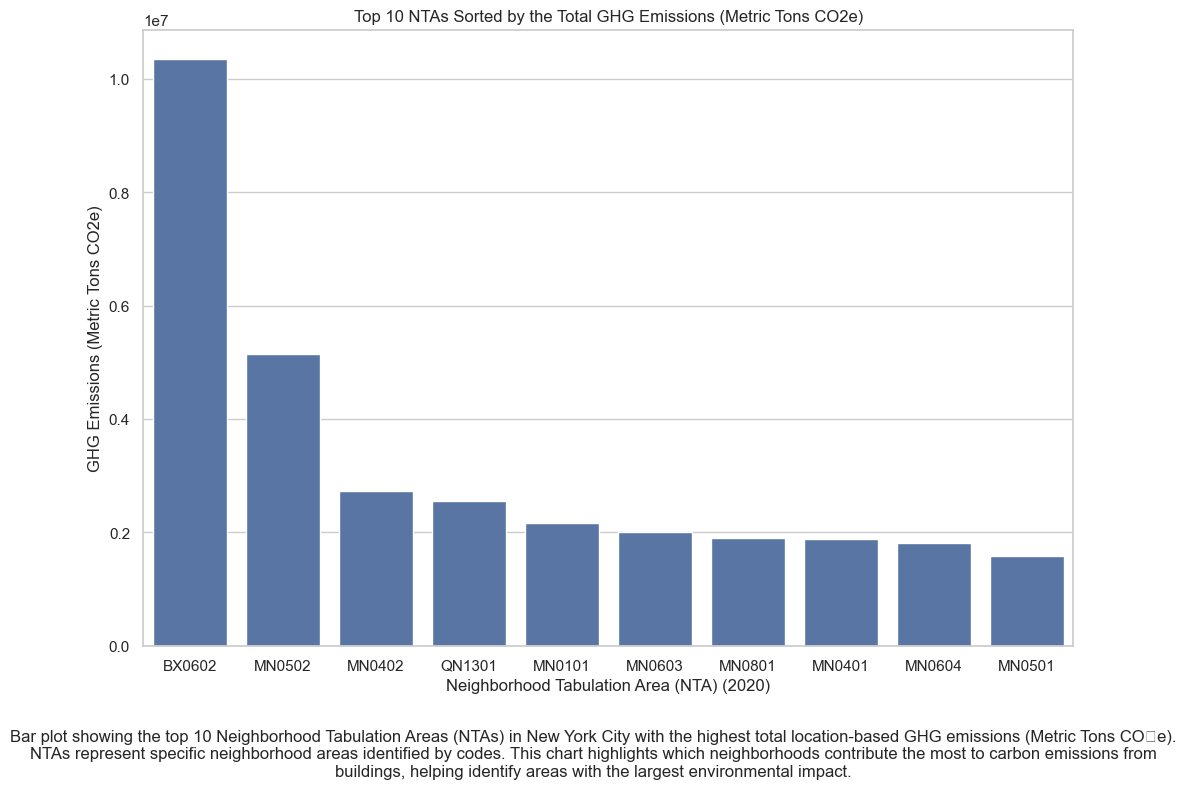

In [63]:
# so here the NTA is a field that indicates the NYC neighborhood area where the building is located. 
# Its represented as like a code. And this barplot shows the Top 20 NTAs sorted by the most total 
# GHG emissions. And these have the most carbon output

nta_ghg = (
    df.groupby("Neighborhood Tabulation Area (NTA) (2020)")["Total (Location-Based) GHG Emissions (Metric Tons CO2e)"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
plt.figure(figsize=(12,8))
sns.barplot(x= nta_ghg.index, y=nta_ghg.values)
plt.title("Top 10 NTAs Sorted by the Total GHG Emissions (Metric Tons CO2e)")
plt.xlabel("Neighborhood Tabulation Area (NTA) (2020)")
plt.ylabel("GHG Emissions (Metric Tons CO2e)")
plt.gcf().text(0.5, -0.05, 
               "Bar plot showing the top 10 Neighborhood Tabulation Areas (NTAs) in New York City with the highest total location-based GHG emissions (Metric Tons CO₂e). NTAs represent specific neighborhood areas identified by codes. This chart highlights which neighborhoods contribute the most to carbon emissions from buildings, helping identify areas with the largest environmental impact.", 
               ha='center', fontsize=12, wrap=True)
plt.show()